## Calculate area-averaged relative vorticity following the vortex 

- Compare calculations from ERA5 reanalysis against global and 4.4 km MetUM forecasts
- Figure 5(a) in the paper

In [1]:
import xarray as xr
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.pyplot as plt

%matplotlib inline

### Define the latitude and longitude bounds for our calculations

In [2]:
lon_start = 88.0
lon_end = 130.0
lat_start = -6.0
lat_end = 23.0

bounds = [lon_start, lon_end, lat_start, lat_end]

### Read in 4.4 km MetUM data and subset

In [3]:
data_path_4p4 = '/nobackup/earshar/borneo/20181021T1200Z_SEA4_km4p4_ra1tld_pverc.nc'
try:
    data_4p4 = xr.open_dataset(data_path_4p4).metpy.parse_cf()
    data_4p4 = data_4p4.sel( longitude = slice(bounds[0], bounds[1]),
                            latitude = slice(bounds[2], bounds[3]),
                            longitude_1 = slice(bounds[0], bounds[1]),
                            latitude_1 = slice(bounds[2], bounds[3]))
except FileNotFoundError:
    print(f'File not found at {data_path_4p4}, please check directory path!')

### Read in global (N768) MetUM data and subset

- Code throws an error related to dimension `hybrid_ht_1` when reading in `umglaa_pe000.nc` file
- Quick fix is to remove this file from the directory path (`data_path_n768`)

In [4]:
data_path_n768 = '/nobackup/earshar/borneo/case_20181021T1200Z_N768_v2/nc/umglaa_pe*.nc'
try:
    data_n768 = xr.open_mfdataset(data_path_n768, combine='by_coords', 
                                  drop_variables=['field83','dz_dt'],
                                  chunks={"t": 5}).metpy.parse_cf()
    data_n768 = data_n768.sel(longitude=slice(bounds[0], bounds[1]),
                            latitude=slice(bounds[2], bounds[3]),
                            longitude_1=slice(bounds[0], bounds[1]),
                            latitude_1=slice(bounds[2], bounds[3])
                            )
except FileNotFoundError:
    print(f'File not found at {data_path_n768}, please check directory path!')

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


### Read in ERA5 data and subset

- Read in ERA5 data for entire month (October 2018)
- Rearrange latitude dimension to run to south to north
- Drop a load of unnecessary variables when opening the dataset
- Select the correct range of dates (12 UTC on 21 October to 12 UTC on 26 October)

In [5]:
data_path_era5 = '/nobackup/earshar/borneo/bv_oct2018.grib'
data_era5 = xr.open_dataset(data_path_era5, 
                            engine="cfgrib",
                            drop_variables=['ciwc','clwc','crwc','cswc','q','r','pv','w','t']).metpy.parse_cf()
data_era5 = data_era5.reindex(latitude=data_era5.latitude[::-1])
data_era5 = data_era5.sel(time = slice('2018-10-21T12', '2018-10-26T12'), 
                          longitude = slice(bounds[0], bounds[1]),
                          latitude = slice(bounds[2], bounds[3]) )

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


### Extract `u` and `v` variables from all datasets

- ERA5, global (N768) MetUM, 4.4 km MetUM
- Select vertical level to calculate circulation (area-averaged relative vorticity)
- Interpolate N768 `v` and `u` variables onto same grid (align coordinates)

In [6]:
plev = 850
u_era5 = data_era5.u.sel(isobaricInhPa=plev,method='nearest')
v_era5 = data_era5.v.sel(isobaricInhPa=plev,method='nearest')
u_4p4 = data_4p4.u.sel(p=plev,method='nearest')
v_4p4 = data_4p4.v.sel(p=plev,method='nearest')
u_n768 = data_n768.u.sel(hybrid_ht_1=int(1.4e+03), method="nearest" )
v_n768 = data_n768.v.sel(hybrid_ht_1=int(1.4e+03), method="nearest" )

v_n768 = v_n768.interp(latitude_1=u_n768.latitude)
u_n768 = u_n768.interp(longitude_1=v_n768.longitude)

### Read in vortex track and intensity data

In [7]:
vortex_path = '/home/home02/earshar/borneo_vortex/borneo_vortex_2018102112_track.txt'
vortex_df = pd.read_csv(vortex_path, sep=' & ', engine='python', na_filter=True, na_values="1.000000e+25")
vortex_df['Time'] = pd.to_datetime(vortex_df['Time'], format='%Y%m%d%H')
bv_lat = vortex_df.loc[0:20, "lat_vort"];
bv_lon = vortex_df.loc[0:20, "lon_vort"]
bv_time = vortex_df.loc[0:20, "Time"]

### Calculate area-averaged vorticity for 4.4 km MetUM 

- Create lists to hold values for plotting 
- Set radius for calculation
- Set indices in vortex array for 12-h intervals (`xi`)

In [8]:
circ_4p4_list = []
circ_era5_list = []
circ_n768_list = []
datetime_list = ['2018-10-21T12', '2018-10-22T00', '2018-10-22T12', '2018-10-23T00', 
                 '2018-10-23T12', '2018-10-24T00', '2018-10-24T12', '2018-10-25T00',
                 '2018-10-25T12', '2018-10-26T00', '2018-10-26T12']
xi = [0,2,4,6,8,10,12,14,16,18,20]
r0 = 3.0

for i, it in enumerate(datetime_list):

    xii = xi[i]
    u_4p4_t0 = u_4p4.sel(t=datetime_list[i])
    v_4p4_t0 = v_4p4.sel(t=datetime_list[i])

    vort_4p4 = mpcalc.vorticity(u_4p4_t0, v_4p4_t0, dx = None, dy = None) * 1000000
    vort_4p4.attrs['units'] = '10-5 s-1'

    circ_4p4 = (vort_4p4.loc[bv_lat[xii]-r0:bv_lat[xii]+r0, bv_lon[xii]-r0:bv_lon[xii]+r0]).mean()
    circ_4p4_list.append(circ_4p4.values)

### Calculate area-averaged vorticity for ERA5

In [9]:
for i, it in enumerate(datetime_list):

    xii = xi[i]
    u_era5_t0 = u_era5.sel(time=datetime_list[i])
    v_era5_t0 = v_era5.sel(time=datetime_list[i])

    vort_era5 = mpcalc.vorticity(u_era5_t0, v_era5_t0, dx = None, dy = None) * 1000000
    vort_era5.attrs['units'] = '10-5 s-1'

    circ_era5 = (vort_era5.loc[bv_lat[xii]-r0:bv_lat[xii]+r0, bv_lon[xii]-r0:bv_lon[xii]+r0]).mean()
    circ_era5_list.append(circ_era5.values)

/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/metpy/xarray.py:350: UserWarning: More than one time coordinate present for variable "u".
  + varname + '.')


### Calculate area-averaged vorticity for global MetUM 

- First two values of the array are blank (need to fix issue with coordinates)
- Need to update indices in vortex array for 12-h intervals

In [10]:
xi_n768 = [4,6,8,10,12,14,16,18,20]
datetime_list_n768 = ['2018-10-22T12', '2018-10-23T00', 
                      '2018-10-23T12', '2018-10-24T00', '2018-10-24T12', '2018-10-25T00',
                      '2018-10-25T12', '2018-10-26T00', '2018-10-26T12']

for i, it in enumerate(datetime_list_n768):

    xii = xi_n768[i]
    u_n768_t0 = u_n768.sel(t=datetime_list_n768[i])
    v_n768_t0 = v_n768.sel(t=datetime_list_n768[i])

    vort_n768 = mpcalc.vorticity(u_n768_t0, v_n768_t0, dx = None, dy = None) * 1000000
    vort_n768.attrs['units'] = '10-5 s-1'

    circ_n768 = (vort_n768.loc[bv_lat[xii]-r0:bv_lat[xii]+r0, bv_lon[xii]-r0:bv_lon[xii]+r0]).mean()
    circ_n768_list.append(circ_n768.values)

/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/metpy/xarray.py:1431: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  warnings.warn('Horizontal dimension numbers not found. Defaulting to '
/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/metpy/xarray.py:1431: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  warnings.warn('Horizontal dimension numbers not found. Defaulting to '
/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/metpy/xarray.py:1431: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  warnings.warn('Horizontal dimension numbers not found. Defaulting to '
/home/home02/earshar/.conda/envs/shardy_env/lib/python3.7/site-packages/metpy/xarray.py:1431: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  warnings.warn('Horizontal dimension numbers not found. Defa

### Produce time-series plot and save the output locally

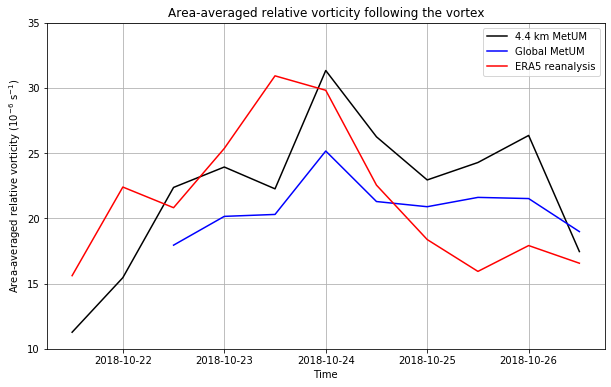

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(bv_time[0:21:2], circ_4p4_list, color='k', label='4.4 km MetUM')
ax.plot(bv_time[4:21:2], circ_n768_list, color='b', label='Global MetUM')
ax.plot(bv_time[0:21:2], circ_era5_list, color='r', label='ERA5 reanalysis')

variable_str = 'Area-averaged relative vorticity'
ax.set(xlabel='Time',
        ylabel=r'Area-averaged relative vorticity ($\mathregular{10}^{-6}$ s$\mathregular{^{-1}}$)',
        ybound=(10, 35),
        title=f'{variable_str} following the vortex')
ax.grid(True)
ax.legend(loc='upper right')
plev_str = str(plev)
fig.savefig(f'fig5a_{r0}deg_{plev_str}.png', dpi=400)